## Offline Sparsification
This notebook performs three task:

s: Linear systems solve using APPR
2. )
2. Online node le over offline sparsified graph
3. ng
3. Clustering

Additions that **sparsification is performed offline**, meaning that the reductions in graph connectivity happen before the computations rather than dynamically during the algt
fline.

---

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix, lil_matrix

from data_loader import *
from sparsify import *
from appr import *
from RelaxRegularizeAPPR import *
from clustering import *

Text(0.5, 1.0, 'Original: political-blog adjacency')

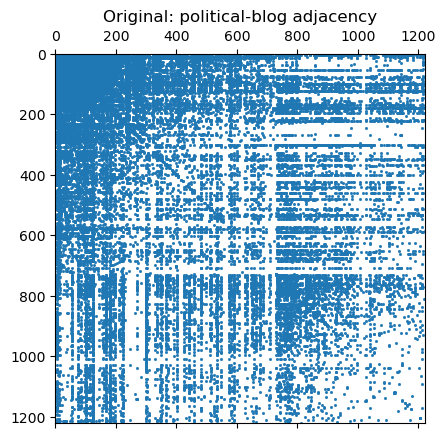

In [2]:
# load test graph
dataset = 'political-blog'
adj_matrix_orig, labels = load_graph_data(dataset)

# compute Laplacian, normalized laplacian, and one-hot embedding of labels
Theta_orig,nTheta_orig, Y_onehot =  prepare_problems(adj_matrix_orig,labels) 

# visualize
plt.spy(adj_matrix_orig,markersize=1)
plt.title('Original: %s adjacency' % dataset)

In [3]:
#stats about unsparsified graph
n = len(labels)
num_classes = max(labels)+1
degree_vector_orig = np.asarray(adj_matrix_orig.sum(axis=1)).flatten()

In [4]:
# We will sparsify so that the c = max degree of the new graph is 2 x the median degree of the original graph.
# To compare, for uniform and resistive sampling we will use the corresponding p = percentage of nodes retained.

c = np.median(degree_vector_orig)*2
p = np.sum(degree_vector_orig[degree_vector_orig < c] / np.sum(degree_vector_orig))
print(c,p)

26.0 0.1904519757111663


11305


Text(0.5, 1.0, 'Sparsified: political-blog adjacency')

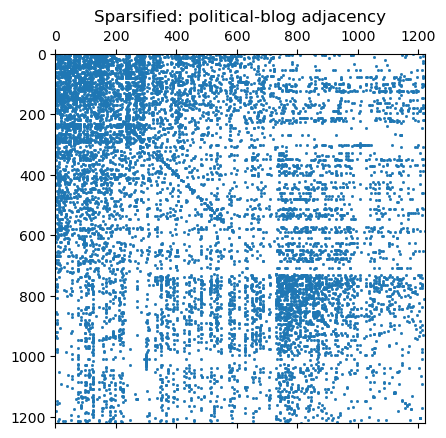

In [5]:
# now we sparsify
sparse = 'influencer' # pick orig, influencer, uniform, resistive
if sparse == 'uniform':
    adj_matrix_sparsify,_ = uniform_sparsify(adj_matrix_orig, p, seed=42)
elif sparse == 'resistive':
    adj_matrix_sparsify,_ = resistive_sparsify(adj_matrix_orig, p, seed=42)
elif sparse == 'influencer':
    adj_matrix_sparsify = influencer_sparsify(adj_matrix_orig, c, seed=42)
degree_vector_sparsify = np.asarray(adj_matrix_sparsify.sum(axis=1)).flatten()

# recompute Laplacian, normalized laplacian, and one-hot embedding of labels
Theta_sparsify, nTheta_sparsify, Y_onehot =  prepare_problems(adj_matrix_sparsify,labels)

# visualize
plt.spy(adj_matrix_sparsify,markersize=1)
plt.title('Sparsified: %s adjacency' % dataset)

## APPR for linear solve

This section explores how APPR can be used to solve linear systems.

In [6]:
#Now, we will solve a linear system, using APPR, on the original and subsampled graph. 


epsilon = 1e-3
y = np.random.randn(n) # random right hand side


beta = 0.1
res = 0.
x = np.zeros(n)
for s in range(n):
    xs,r = appr(adj_matrix_sparsify,degree_vector_sparsify, epsilon = epsilon, 
                                    alpha= 1 - 2*beta, s = s,maxiter = 100, seed = 42)
    x = x + y[s]*xs
    res += np.linalg.norm(r)
print('Residual norm for APPR: %e' % res)
    

# Now run the original unsparsified system
x_orig = np.zeros(n)
for s in range(n):
    xs,r = appr(adj_matrix_orig,degree_vector_orig, epsilon = epsilon, 
                                    alpha= 1 - 2*beta, s = s,maxiter = 100, seed = 42)
    x_orig = x_orig + y[s]*xs
print('Difference with original adj.: %e' % np.linalg.norm(x-x_orig))

# compare against direct solve
x_true,_ = ppr_solve(adj_matrix_orig,degree_vector_orig,alpha=1 - 2*beta,y=y)
print('Difference with true x.: %e' % np.linalg.norm(x-x_true))


Residual norm for APPR: 7.203925e+01
Difference with original adj.: 3.015010e+00
Difference with true x.: 3.092897e+00


## Online node labeling via regularization method (Belkin et al)


In [7]:
# compute smoothness term

beta = 0.9 
epsilon = 1e-3
T= beta * nTheta_sparsify + (1. - beta) * np.eye(n)
sigma = ( Y_onehot.T @ (T @ Y_onehot)).diagonal().sum()

#without sparsification

out = Regularize_APPR(adj_matrix_orig,degree_vector_orig,
                epsilon, beta, sigma,  Y_onehot, seed = 42,
                maxneighbors = None, maxiter = 100)

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate without sparsification: %e' % misclass)

# with sparsification
out = Regularize_APPR(adj_matrix_sparsify,degree_vector_sparsify,
                epsilon, beta, sigma,  Y_onehot, seed = 42,
                maxneighbors = None, maxiter = 100)

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate with sparsification: %e' % misclass)


100%|██████████| 1222/1222 [00:02<00:00, 605.01it/s]


Misclassification rate without sparsification: 2.348609e-01


100%|██████████| 1222/1222 [00:02<00:00, 495.73it/s]

Misclassification rate with sparsification: 2.356792e-01


## Online node labeling via relaxation method (Rakhlin et al)

In [8]:
# compute smoothness term, and Delta

beta = 0.9 
epsilon = 1e-3
T= beta * nTheta_sparsify + (1. - beta) * np.eye(n)
sigma = ( Y_onehot.T @ (T @ Y_onehot)).diagonal().sum()
Delta = num_classes

#without sparsification

out = Relaxation_APPR(adj_matrix_orig,degree_vector_orig,
                epsilon, beta, sigma, Delta,  Y_onehot, seed = 42,
                maxneighbors = None, maxiter = 100)

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate without sparsification: %e' % misclass)

# with sparsification
out = Relaxation_APPR(adj_matrix_sparsify,degree_vector_sparsify,
                epsilon, beta, sigma, Delta, Y_onehot, seed = 42,
                maxneighbors = None, maxiter = 100)

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate with sparsification: %e' % misclass)




100%|██████████| 1222/1222 [00:01<00:00, 617.69it/s]


Misclassification rate without sparsification: 2.602291e-01


100%|██████████| 1222/1222 [00:02<00:00, 478.28it/s]


Misclassification rate with sparsification: 2.765957e-01


## Clustering via subsampled approximate PPR

In [9]:
beta = 0.4 
alpha = 1 - 2*beta
num_clusters = num_classes*10
epsilon = 1e-4

cluster_map = get_cluster_map(adj_matrix_orig, degree_vector_orig, epsilon, alpha)
seeds = get_popular_seeds(cluster_map,num_clusters)
score,  cluster_assign = cluster_ppr(cluster_map,seeds, labels,num_clusters)
print(cluster_assign)
print('Cluster score, no sparsification: %e' % score)

cluster_map = get_cluster_map(adj_matrix_sparsify,degree_vector_sparsify, epsilon, alpha)
seeds = get_popular_seeds(cluster_map,num_clusters)
score,  cluster_assign = cluster_ppr(cluster_map,seeds, labels,num_clusters)
print('Cluster score, with sparsification: %e' % score)

100%|██████████| 1222/1222 [00:19<00:00, 61.51it/s]


[ 5  0  2 ...  7 17 -1]
Cluster score, no sparsification: 6.538462e-01


100%|██████████| 1222/1222 [00:15<00:00, 80.53it/s]


Cluster score, with sparsification: 4.263502e-01
